In [1]:
!pip install lightgbm xgboost scikit-optimize catboost dask cloudpickle

  Using cached https://files.pythonhosted.org/packages/bf/01/45e209af10fd16537df0c5d8a5474c286554c3eaf9ddb0ce04113f1e8506/lightgbm-2.1.1-py2.py3-none-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f4/44/60f82c97d1caa98752c7da2c1681cab5c7a390a0fdd3a55fac672b321cac/scikit_optimize-0.5.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/49/98/67ab754fb1579da74c334e4e7683b113149d6f254b73bdce4bdf61a6b52c/catboost-0.8.1.1-cp35-none-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/aa/18/514b557c4d8d4ada1f0454ad06c845454ad438fd5c5e0039ba51d6b032fe/cloudpickle-0.5.2-py2.py3-none-any.whl
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import subprocess
data_source_path = 'gs://onead-gcpml/ninja_project/output/feature_data_6000.csv'
local_source_path = '../input/'
cmd = "gsutil -m cp {} {}".format(data_source_path, local_source_path)
subprocess.check_call(cmd, shell=True)

0

In [ ]:
import subprocess
data_source_path = 'gs://onead-gcpml/ninja_project/data/talkingdata-adtracking-fraud-detection/*.csv'
local_source_path = '../input/'
cmd = "gsutil -m cp {} {}".format(data_source_path, local_source_path)
subprocess.check_call(cmd, shell=True)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import lightgbm as lgb
import os
import gc
import subprocess
import traceback
import multiprocessing
from datetime import datetime
from pathlib import Path
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.python.lib.io import file_io
import tensorflow as tf
import matplotlib.pyplot as plt
import dask.dataframe as dd
from catboost import CatBoostClassifier

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
"""
%%time
dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8',
    'click_id': 'uint32'
    }
data_prefix = 'gs://onead-gcpml/ninja_project/data/talkingdata-adtracking-fraud-detection'
file_list = tf.gfile.ListDirectory(data_prefix)
file = os.path.join(data_prefix, 'train.csv')
with file_io.FileIO(file, mode='rb') as input_f:
   train = pd.read_csv(input_f, skiprows=range(1, 131886954), nrows=40000000, dtype=dtypes, 
                       usecols=['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed'])
"""                       

CPU times: user 2min 19s, sys: 27.8 s, total: 2min 47s
Wall time: 4min 26s


In [6]:
%%time
debug = 0
total_nrows = 184903891 - 1
nchuck = 0 
main_path = Path('../input')
# print(os.listdir(str(main_path)))

# Any results you write to the current directory are saved as output.
dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8',
    'click_id': 'uint32'
    }

if debug:
  train_rows = 1000000
  print('Loading test data...')
  test_data = pd.read_csv(main_path / 'test.csv', dtype=dtypes, parse_dates=['click_time'], 
                          nrows=100000,
                          usecols=['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id'])
  length_of_train = len(train_data)
else:
  train_rows = total_nrows
  print('Loading test data...')
  test_data = pd.read_csv(main_path / 'test.csv', dtype=dtypes, parse_dates=['click_time'], 
                          usecols=['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id'])
  
print('Loading train data...')
train_data = pd.read_csv(main_path / 'train.csv', dtype=dtypes, nrows=train_rows,
                         parse_dates=['click_time'],
                         usecols=['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed'])  
length_of_train = len(train_data)
train_data = train_data.append(test_data)

Loading test data...
Loading train data...
CPU times: user 3min 33s, sys: 21.7 s, total: 3min 55s
Wall time: 3min 54s


In [7]:
train_data.shape, test_data.shape

((203694359, 8), (18790469, 7))

In [5]:
%%time
# load feature data
main_path = Path('../input')
train_data = pd.read_csv(main_path / 'feature_data_4000.csv')  
length_of_train = 40000000

CPU times: user 2min 55s, sys: 37.9 s, total: 3min 33s
Wall time: 3min 33s


In [6]:
train_data.shape

(58790469, 28)

# Feature Engineering

### Define common function 

In [8]:
    def time_labels(t):
        most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
        least_freq_hours_in_test_data = [6, 11, 15]
        if t in most_freq_hours_in_test_data:
            res = 1
        elif t in least_freq_hours_in_test_data:
            res = 3
        else:
            res = 2
        return res

    def do_count(data, group_cols, target_col, new_col_name, col_type):
        print('[INFO] Count {} with group by {} combination...'.format(target_col, '-'.join(group_cols)))
        cols = group_cols.copy()
        cols.append(target_col)
        group_data = data[cols].groupby(by=group_cols)[[target_col]].count().reset_index().\
            rename(index=str, columns={target_col: new_col_name})
        data = data.merge(group_data, on=group_cols, how='left')
        del group_data
        data[new_col_name] = data[new_col_name].astype(col_type)
        gc.collect()
        return data

    def do_count_unique(data, group_cols, target_col, new_col_name, col_type):
        print('[INFO] Count unique {} with group by {} combination...'.format(target_col, '-'.join(group_cols)))
        cols = group_cols.copy()
        cols.append(target_col)
        group_data = data[cols].groupby(by=group_cols)[[target_col]].nunique().reset_index().\
            rename(index=str, columns={target_col: new_col_name})
        data = data.merge(group_data, on=group_cols, how='left')
        del group_data
        data[new_col_name] = data[new_col_name].astype(col_type)
        gc.collect()
        return data

    def do_cumcount(data, group_cols, target_col, new_col_name, col_type):
        print('[INFO] Cumcount {} with group by {} combination...'.format(target_col, '-'.join(group_cols)))
        cols = group_cols.copy()
        cols.append(target_col)
        group_data = data[cols].groupby(by=group_cols)[[target_col]].cumcount()
        data[new_col_name] = group_data.values
        del group_data
        data[new_col_name] = data[new_col_name].astype(col_type)
        gc.collect()
        return data

    def do_mean(data, group_cols, target_col, new_col_name, col_type):
        print('[INFO] Compute mean {} with group by {} combination...'.format(target_col, '-'.join(group_cols)))
        cols = group_cols.copy()
        cols.append(target_col)
        group_data = data[cols].groupby(by=group_cols)[[target_col]].mean().reset_index().\
            rename(index=str, columns={target_col: new_col_name})
        data = data.merge(group_data, on=group_cols, how='left')
        del group_data
        # data[new_col_name] = data[new_col_name].astype(col_type)
        gc.collect()
        return data

    def do_var(data, group_cols, target_col, new_col_name, col_type):
        print('[INFO] Compute var {} with group by {} combination...'.format(target_col, '-'.join(group_cols)))
        cols = group_cols.copy()
        cols.append(target_col)
        group_data = data[cols].groupby(by=group_cols)[[target_col]].var().reset_index().\
            rename(index=str, columns={target_col: new_col_name})
        data = data.merge(group_data, on=group_cols, how='left')
        del group_data
        # data[new_col_name] = data[new_col_name].astype(col_type)
        gc.collect()
        return data

    def next_click(data):
        # next_click: 定義user在不同時間點不同的channel中看到相同的app，click_buffer保留最後一個click的時間
        # The log2-transformed and rounded counts are further hashed with the feature name. So the original feature
        # gets mapped into separate features in the log-scale bins. This improves the score considerably and allows
        # modeling a non-linear response for each feature. Factors further model interactions between the
        # non-linear, although I haven't tested how much this contributes.
        D= 2**26
        data['category'] = (data['ip'].astype(str) + "_" + data['app'].astype(str) + "_" +
                            data['device'].astype(str) + "_" + data['os'].astype(str)).apply(hash) % D
        # 預先initial一個非常大的時間
        # Click_buffer maintains the last seen times of clicks for each category. For each click, you look if there's
        # been a previous click, and compute the time difference. This is done in reverse, and reversing the output
        # list next_clicks at the end gives the times of next clicks in the correct order.
        click_buffer= np.full(D, 3000000000, dtype=np.uint32)
        data['epochtime'] = data['click_time'].astype(np.int64) // 10 ** 9
        next_clicks= []
        for category, time in zip(reversed(data['category'].values), reversed(data['epochtime'].values)):
            next_clicks.append(click_buffer[category]-time)
            click_buffer[category]= time
        del(click_buffer)
        data.drop(['epochtime'], axis=1, inplace=True)
        data['next_click'] = list(reversed(next_clicks))
        return data

    def previous_click(data):
        D = 2**26
        data['category'] = (data['ip'].astype(str) + "_" + data['app'].astype(str) + "_" +
                            data['device'].astype(str) + "_" + data['os'].astype(str)).apply(hash) % D
        click_buffer= np.full(D, 3000000000, dtype=np.uint32)
        data['epochtime'] = data['click_time'].astype(np.int64) // 10 ** 9
        prev_clicks= []
        for category, time in zip(data['category'].values, data['epochtime'].values):
            prev_clicks.append(time-click_buffer[category])
            click_buffer[category]= time
        del(click_buffer)
        data.drop(['epochtime'], axis=1, inplace=True)
        data['prev_click'] = prev_clicks
        return data

    def do_next_click(data, group_cols, col_type):
        print('[INFO] Compute next click with group by {} combination...'.format('-'.join(group_cols)))
        # Calculate the time to next click for each group
        # Name of new feature
        new_feature = '{}_nextClick'.format('_'.join(group_cols))

        # Unique list of features to select
        all_features = group_cols + ['click_time']
        data[new_feature] = (data[all_features].groupby(group_cols).click_time.shift(-1) -
                             data.click_time).dt.seconds.astype(col_type)
        gc.collect()
        return data
      
    def do_prev_click(data, group_cols, col_type):
        print('[INFO] Compute prev click with group by {} combination...'.format('-'.join(group_cols)))
        # Calculate the time to next click for each group
        # Name of new feature
        new_feature = '{}_prevClick'.format('_'.join(group_cols))

        # Unique list of features to select
        all_features = group_cols + ['click_time']
        data[new_feature] = (data.click_time - data[all_features].groupby(group_cols).click_time.shift(+1)).\
            dt.seconds.astype(col_type)
        gc.collect()
        return data

### Time features

In [9]:
print('Extract new time features...')
train_data['hour'] = train_data['click_time'].dt.hour.astype('uint8')
train_data['day'] = train_data['click_time'].dt.day.astype('uint8')
train_data['minute'] = train_data['click_time'].dt.minute.astype('uint8')
train_data['second'] = train_data['click_time'].dt.second.astype('uint8')
gc.collect()

Extract new time features...


79

## Version - 1

1. Added 4 new Features.<br/>
For simplicity define an (ip,device,os) combination as a user instance.<br/>
The 4 new features are:<br/>
    * total count of a unique user instance.
    * a running count of this particular user instance's visit number.For the first time a user instance appears, its 1 , the next time its 2 and so on.
    * total count of a unique user instance and a unique app.
    * a running count of this particular user instance using a particular app.
    For the first time a user appears with a unique app, its 1 , the next time the same user
    appearing with the same app its 2 and so on.
 
2. Some cosmetic changes.<br/>
    * Modified to train on 40 million rows, since we added new features.
    * set seed to 202109
    * validation ratio to 0.9
    
> Refference:
* https://www.kaggle.com/krishnakesavan/r-lgbm-single-model-40m-rows-lb-0-9736/code
* https://www.kaggle.com/pranav84/double-xgb-hist-example-for-chunk-processing/code
* https://www.kaggle.com/pranav84/lightgbm-fixing-unbalanced-data-lb-0-9680/code

In [7]:
most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
least_freq_hours_in_test_data = [6, 11, 15]
def time_labels(t):
    if t in most_freq_hours_in_test_data:
        res = 1
    elif t in least_freq_hours_in_test_data:
        res = 3
    else:
        res = 2
    return res  

train_data['in_test_hh'] = train_data['hour'].apply(time_labels)  
train_data['in_test_hh'] = train_data['in_test_hh'].astype('uint8')

In [8]:
# count channel with group ip-app-device-os
train_data = do_count(data=train_data, group_cols=['ip', 'app', 'device', 'os'], target_col='channel', 
                      new_col_name='UsrappCount', col_type='uint16')
train_data['UsrappNewness'] = train_data.groupby(['ip', 'app', 'device', 'os']).cumcount() + 1
train_data['UsrappNewness'] = train_data['UsrappNewness'].astype('uint16')

# count channel with group ip-device-os
train_data = do_count(data=train_data, group_cols=['ip', 'device', 'os'], target_col='channel', 
                      new_col_name='UsrCount', col_type='uint16')

train_data['UsrNewness'] = train_data.groupby(['ip', 'device', 'os']).cumcount() + 1
train_data['UsrNewness'] = train_data['UsrNewness'].astype('uint16')
train_data['UsrNewness'] = train_data['UsrNewness'].astype('uint16')

[INFO] Count channel with group by ip-app-device-os combination...
[INFO] Count channel with group by ip-device-os combination...


In [10]:
# count channel with group ip-day-in_test_hh
train_data = do_count(data=train_data, group_cols=['ip', 'day', 'in_test_hh'], target_col='channel', 
                      new_col_name='n_ip_day_test_hh', col_type='uint32')
train_data.drop(['in_test_hh'], axis=1, inplace=True)

# count channel with group ip-day-hour
train_data = do_count(data=train_data, group_cols=['ip', 'day', 'hour'], target_col='channel', 
                      new_col_name='n_ip', col_type='uint16')

# count channel with group ip-day-hour-os
train_data = do_count(data=train_data, group_cols=['ip', 'day', 'hour', 'os'], target_col='channel', 
                      new_col_name='n_ip_os', col_type='uint32')

# count channel with group ip-day-hour-app
train_data = do_count(data=train_data, group_cols=['ip', 'day', 'hour', 'app'], target_col='channel', 
                      new_col_name='n_ip_app', col_type='uint16')

# count channel with group ip-day-hour-app-os
train_data = do_count(data=train_data, group_cols=['ip', 'day', 'hour', 'app', 'os'], target_col='channel', 
                      new_col_name='n_ip_app_os', col_type='uint16')

# count channel with group app-day-hour
train_data = do_count(data=train_data, group_cols=['app', 'day', 'hour'], target_col='channel', 
                      new_col_name='n_app', col_type='uint16')

[INFO] Count channel with group by ip-day-in_test_hh combination...
[INFO] Count channel with group by ip-day-hour combination...
[INFO] Count channel with group by ip-day-hour-os combination...
[INFO] Count channel with group by ip-day-hour-app combination...
[INFO] Count channel with group by ip-day-hour-app-os combination...
[INFO] Count channel with group by app-day-hour combination...


In [12]:

train_data = next_click(data=train_data)
train_data = previous_click(data=train_data)

train_data = do_count(data=train_data, group_cols=['device', 'channel', 'hour'], target_col='app', 
                      new_col_name='n_dev_channel', col_type='uint32')
train_data = do_count(data=train_data, group_cols=['device', 'channel', 'hour', 'app'], target_col='os', 
                      new_col_name='n_dev_channel_app', col_type='uint32')
train_data['app_confRate'] = train_data['n_dev_channel_app']/train_data['n_dev_channel']
train_data.drop(['ip', 'day', 'click_time', 'n_dev_channel', 'n_dev_channel_app'], axis=1, inplace=True)
gc.collect()


In [9]:
train_data.drop(['ip', 'day', 'click_time'], axis=1, inplace=True)
gc.collect()

79

## Version - 2

In [ ]:
try:
  train_data = do_count_unique(data=train_data, group_cols=['ip'],
                               target_col='channel', new_col_name='uni_ip_with_ch', col_type='uint32')
  train_data = do_count_unique(data=train_data, group_cols=['ip', 'device', 'os'],
                               target_col='app', new_col_name='uni_ip_dev_os', col_type='uint32')
  train_data = do_count_unique(data=train_data, group_cols=['ip', 'day'],
                               target_col='hour', new_col_name='uni_ip_day', col_type='uint32')
  train_data = do_count_unique(data=train_data, group_cols=['ip'],
                               target_col='app', new_col_name='uni_ip_with_app', col_type='uint32')
  train_data = do_count_unique(data=train_data, group_cols=['ip', 'app'],
                               target_col='os', new_col_name='uni_ip_app', col_type='uint32')
  train_data = do_count_unique(data=train_data, group_cols=['ip'],
                               target_col='device', new_col_name='uni_ip_with_dev', col_type='uint32')
  train_data = do_count_unique(data=train_data, group_cols=['app'],
                               target_col='channel', new_col_name='uni_app_with_ch', col_type='uint32')

  train_data = do_cumcount(data=train_data, group_cols=['ip'],
                           target_col='os', new_col_name='cum_ip', col_type='uint32')
  train_data = do_cumcount(data=train_data, group_cols=['ip', 'device', 'os'],
                           target_col='app', new_col_name='cum_ip_dev_os', col_type='uint32')
  
  train_data = do_count(data=train_data, group_cols=['ip', 'day', 'hour'],
                        target_col='channel', new_col_name='count_ip_day_hour', col_type='uint32')
  train_data = do_count(data=train_data, group_cols=['ip', 'app'],
                        target_col='channel', new_col_name='count_app', col_type='uint32')
  train_data = do_count(data=train_data, group_cols=['ip', 'app', 'os'],
                        target_col='channel', new_col_name='count_ip_app_os', col_type='uint32')

  #train_data = do_var(data=train_data, group_cols=['ip', 'day', 'channel'],
  #                              target_col='hour', new_col_name='var_ip_day_ch', col_type='float32')  
  train_data = do_var(data=train_data, group_cols=['ip', 'app', 'os'],
                      target_col='hour', new_col_name='var_ip_app_os', col_type='float32')  
  #train_data = do_var(data=train_data, group_cols=['ip', 'app', 'channel'],
  #                              target_col='day', new_col_name='var_ip_app_ch', col_type='float32')
  train_data = do_mean(data=train_data, group_cols=['ip', 'app', 'channel'],
                       target_col='hour', new_col_name='mean_ip_app_ch', col_type='float32')

  train_data = do_next_click(data=train_data, group_cols=['ip', 'app', 'device', 'os', 'channel'],
                             col_type='float32')
  train_data = do_next_click(data=train_data, group_cols=['ip', 'os', 'device'],
                             col_type='float32')
  train_data = do_next_click(data=train_data, group_cols=['ip', 'os', 'device', 'app'],
                             col_type='float32')
  train_data = do_next_click(data=train_data, group_cols=['device', 'channel'],
                             col_type='float32')
  train_data = do_next_click(data=train_data, group_cols=['app', 'device', 'channel'],
                             col_type='float32')
  train_data = do_prev_click(data=train_data, group_cols=['ip', 'channel'],
                             col_type='float32')
  train_data = do_prev_click(data=train_data, group_cols=['ip', 'os'],
                             col_type='float32')
  #train_data = next_click(data=train_data)
  #train_data = previous_click(data=train_data)
except Exception as e:
  print(e, traceback.print_exc(()))           

[INFO] Count unique channel with group by ip combination...
[INFO] Count unique app with group by ip-device-os combination...
[INFO] Count unique hour with group by ip-day combination...
[INFO] Count unique app with group by ip combination...
[INFO] Count unique os with group by ip-app combination...
[INFO] Count unique device with group by ip combination...
[INFO] Count unique channel with group by app combination...


In [ ]:
# remove useless features
print('[INFO] Remove useless features')
train_data.drop(['ip', 'day', 'click_time'], axis=1, inplace=True)
gc.collect()

In [ ]:
train_data.columns

In [ ]:
local_data_path = Path('/tmp')
output_path = "gs://onead-gcpml/ninja_project/output"
train_data.to_csv(str(local_data_path / 'feature_data_4000_server.csv'), index=False)
cmd = 'gsutil cp {} {}'.format(str(local_data_path / 'feature_data.csv'), output_path)
subprocess.check_call(cmd, shell=True)
gc.collect()

## Version - 3 
<br/>
#### Confidence Rates for is_attributed
My thought is that some ips, apps, devices, etc. might have higher frequencies of is_attributed, and I wish to add that information, i.e. I'm calculating the following "attributed rates":

$ P\left(is\_attributed\middle|category\right) $
 
or in some cases two- or multiple-paired combinations:

$ P\left(is\_attributed\middle|category\_1, category\_2\right)$
 
The danger of this is that if a given category-combination has very few clicks, then the statistical significance of above equations cannot be trusted. Therefore I'll be weighing the rates by the following confidence rates:

$ conf_{is\_attributed} = \frac{log(views_{category\_1})}{log(100000)}$
 
where the value 100000 has been chosen arbitrarily to such that if a given category has 1000 views, then it gets a confidence weight of 60%, if it has 100 views then onfly a confidence weight of 40% etc.

*Reference*
* https://www.kaggle.com/nanomathias/feature-engineering-importance-testing

In [ ]:
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ###############
    ['ip'], ['app'], ['device'], ['os'], ['channel'],    
    # V2 Features #
    ['app', 'channel'], ['app', 'os'], ['app', 'device'],    
    # V3 Features #
    ['channel', 'os'], ['channel', 'device'], ['os', 'device']
]

def confidence_rate(x):
    if x.count() >0:
        rate = x.sum() / float(x.count() + 0.00001)
        conf = np.min([1, np.log(x.count())/np.log(100000)])
        res = rate*conf
    else:
        res = 0
    return res

for cols in ATTRIBUTION_CATEGORIES:
  print('[INFO] Compute {} confidence rate...'.format('-'.join(cols)))
  new_feature = '_'.join(cols)+'_confRate'  
  cols.append('is_attributed')
  group_data = train_data[cols].groupby(by=cols[:-1])[cols[-1]].apply(confidence_rate).reset_index().rename(index=str, columns={'is_attributed': new_feature})
  train_data = train_data.merge(group_data, on=cols[:-1], how='left')
  del group_data
  gc.collect()

# Split data

In [7]:
split_probability = 0.1
seed = 202109
test_df = train_data[length_of_train:]
train_df, validation_df = train_test_split(train_data[:length_of_train], 
                                           test_size=split_probability, 
                                           random_state=seed)
#validation_df = train_data[(length_of_train-validation_boundary):length_of_train]
#train_df = train_data[:(length_of_train-validation_boundary)]

print("train size: ", len(train_df))
print("valid size: ", len(validation_df))
print("test size : ", len(test_df))

train size:  36000000
valid size:  4000000
test size :  18790469


In [8]:
target = 'is_attributed'
categorical_features = [col for col in train_df.columns if col in ['app', 'device', 'os', 'channel', 'day', 'hour', 'minute', 'second']]
predictors = list(train_df.columns.get_values()).copy()
predictors.remove(target)
predictors.remove('click_id')


In [9]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype('int')
gc.collect()

85

# CatBoost

In [10]:
categorical_index = [predictors.index(c) for c in categorical_features]
categorical_index

[0, 1, 2, 3, 4, 5, 6]

In [11]:
%%time
from catboost import Pool
train_pool = Pool(data=train_df[predictors], label=train_df[target], cat_features=categorical_index)


CPU times: user 9min 55s, sys: 15.4 s, total: 10min 10s
Wall time: 10min 8s


In [ ]:
%%time
valid_pool = Pool(data=validation_df[predictors], label=validation_df[target], cat_features=categorical_index)

CPU times: user 1min 6s, sys: 1.32 s, total: 1min 8s
Wall time: 1min 8s


In [ ]:
%%time
test_pool = Pool(data=test_df[predictors], cat_features=categorical_index)

In [ ]:
number_of_iter = 500
params = {
  'iterations': number_of_iter, # alias n_estimators
  'learning_rate' : 0.1, # alias eta
  'depth': 6, # alias max_depth
  'loss_function': 'Logloss',
  'l2_leaf_reg': 5, # L2 regularization coefficient. Used for leaf value calculation.
  # 'subsample': 0.7, # Can't used when bootstrap_type = 'Bayesian'(default).
  'colsample_bylevel': 0.7,
  'scale_pos_weight': 99.7,
  'eval_metric': 'AUC',
  'random_state': 202109,
  'calc_feature_importance': True,
  'thread_count': multiprocessing.cpu_count()-1,
  'verbose': True
  # 'one_hot_max_size': 31 # Use one-hot encoding for all features with number of different values less than or equal to the given parameter value
  # 'ignored_features'
}
catboost_model = CatBoostClassifier(**params, od_type='Iter', od_wait=10)
gc.collect()

In [ ]:
catboost_model.get_params()

In [ ]:
#catboost_model.fit(train_df[predictors], train_df[target], cat_features=categorical_index,
#                   eval_set=(validation_df[predictors], validation_df[target]), 
#                   use_best_model=True, verbose=True, plot=False)

catboost_model.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=True, plot=False)

In [32]:
pred = catboost_model.predict_proba(data=test_df[predictors])[:, 1]

In [ ]:
(np.exp(pred) - 1.0).clip(0,1)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


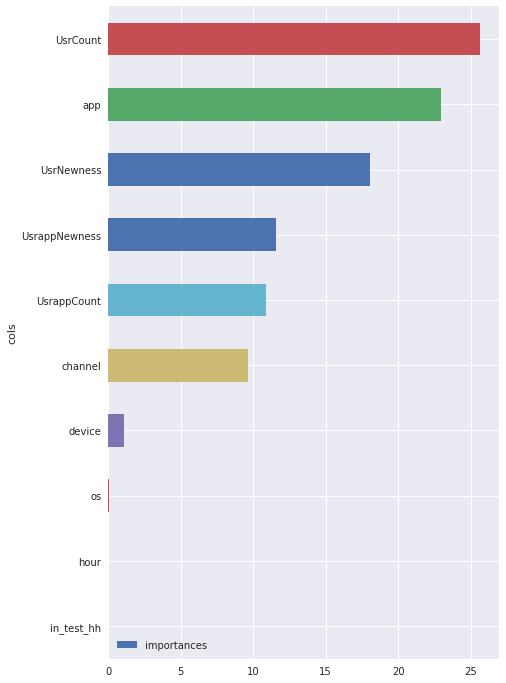

In [35]:
import matplotlib.pyplot as plt

imp_df = pd.DataFrame({'importances': catboost_model.feature_importances_, 'cols':predictors})
imp_df = imp_df.sort_values(['importances','cols'], ascending=[True, False])
_ = imp_df.plot(kind='barh', x='cols', y='importances', figsize=(7,12))
plt.savefig('catboost_feature_importance.png')

# Optimizaiton

In [ ]:
number_of_iter = 1000
bayes_cv_tuner = BayesSearchCV(
  estimator = lgb.LGBMClassifier(objective='binary', metric='auc', n_jobs=1, verbose=0),
  search_spaces = {'learning_rate': (0.01, 0.1, 'log-uniform'),
                   'num_leaves': (1, 10),
                   'max_depth': (0, 10),
                   'min_child_samples': (0, 50),
                   'max_bin': (100, 1000),
                   'subsample': (0.3, 1.0, 'uniform'),
                   'subsample_freq': (0, 10),
                   'colsample_bytree': (0.3, 1.0, 'uniform'),
                   'min_child_weight': (0, 10),
                   'subsample_for_bin': (100000, 500000),
                   'reg_lambda': (1e-9, 1000, 'log-uniform'),
                   'reg_alpha': (1e-9, 1.0, 'log-uniform'),
                   'scale_pos_weight': (1e-6, 500, 'log-uniform')},
  scoring = 'roc_auc',
  cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed),
  n_jobs = 1,
  n_iter = number_of_iter,
  verbose = 0,
  refit = True,
  random_state = seed)
# Fit the model
def status_print(optim_result):
  """Status callback durring bayesian hyperparameter search"""
  # Get all the models tested so far in DataFrame format
  all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)

  # Get current parameters and the best parameters
  best_params = pd.Series(bayes_cv_tuner.best_params_)
  print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(len(all_models),
                                                                np.round(bayes_cv_tuner.best_score_, 4),
                                                                bayes_cv_tuner.best_params_))
  # Save all model results
  clf_name = bayes_cv_tuner.estimator.__class__.__name__
  output_path = os.path.join('/tmp', (clf_name + "_cv_results.csv"))
  all_models.to_csv(output_path)
  cmd = 'gsutil cp {} {}'.format(output_path, 'gs://onead-gcpml/ninja_project/output')
  res = subprocess.check_call(cmd, shell=True)

result = bayes_cv_tuner.fit(train_df[predictors].values, train_df[target].values)


# LGBM

In [71]:
start_time = time.time()
params = {
  'boosting_type': 'gbdt',
  'objective': 'binary',
  'metric': 'auc',
  'learning_rate': 0.1,
  #'is_unbalance': 'true', # replaced with scale_pos_weight argument
  'num_leaves': 7,  # 2^max_depth - 1
  'max_depth': 4,  # -1 means no limit
  'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
  'max_bin': 100,  # Number of bucketed bin for feature values
  'subsample': 0.7,  # Subsample ratio of the training instance.
  'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
  'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
  'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
  'scale_pos_weight': 99.7, # because training data is extremely unbalanced 
  'subsample_for_bin': 200000,  # Number of samples for constructing bin
  'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
  'reg_alpha': 0,  # L1 regularization term on weights
  'reg_lambda': 0,  # L2 regularization term on weights
  'nthread': multiprocessing.cpu_count()-1,
  'verbose': 0,
}

In [ ]:
#lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, 
#n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, 
#min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=1, colsample_bytree=1.0,
#reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, **kwargs)
#number_of_iter = 3000
#estimator = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='auc', n_estimators=3000,
#                               n_jobs=multiprocessing.cpu_count()-1, verbose=True)

#model = estimator.fit(train_df[predictors].values, train_df[target].values, 
#                      eval_metric='auc', early_stopping_rounds=20, 
#                      eval_set=[(validation_df[predictors].values, validation_df[target].values)], 
#                      eval_class_weight=[0.03, 99.7],
#                      eval_names=['valid'], feature_name=predictors, 
#                      categorical_feature=categorical_features)

In [ ]:
  %%time
  # Classifier
  number_of_iter = 1000
  bayes_cv_tuner = BayesSearchCV(
      estimator = lgb.LGBMClassifier(objective='binary', metric='auc', n_jobs=1, verbose=0),
      search_spaces = {
          'learning_rate': (0.01, 1.0, 'log-uniform'),
          'num_leaves': (1, 100),      
          'max_depth': (0, 50),
          'min_child_samples': (0, 50),
          'max_bin': (100, 1000),
          'subsample': (0.01, 1.0, 'uniform'),
          'subsample_freq': (0, 10),
          'colsample_bytree': (0.01, 1.0, 'uniform'),
          'min_child_weight': (0, 10),
          'subsample_for_bin': (100000, 500000),
          'reg_lambda': (1e-9, 1000, 'log-uniform'),
          'reg_alpha': (1e-9, 1.0, 'log-uniform'),
          'scale_pos_weight': (1e-6, 500, 'log-uniform'),
          'n_estimators': (50, 100),
      },    
      scoring = 'roc_auc',
      cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed),
      n_jobs = 1,
      n_iter = number_of_iter,   
      verbose = 0,
      refit = True,
      random_state = seed
  )

  def status_print(optim_result):
      """Status callback durring bayesian hyperparameter search""" 
      # Get all the models tested so far in DataFrame format
      all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    

      # Get current parameters and the best parameters    
      best_params = pd.Series(bayes_cv_tuner.best_params_)
      print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
          len(all_models),
          np.round(bayes_cv_tuner.best_score_, 4),
          bayes_cv_tuner.best_params_
      ))

      # Save all model results
      clf_name = bayes_cv_tuner.estimator.__class__.__name__
      all_models.to_csv(clf_name+"_cv_results.csv")

  # Fit the model
  result = bayes_cv_tuner.fit(train_df[predictors].values, train_df[target].values)

In [ ]:
print('Training...')
number_of_iter = 3000
x_train = lgb.Dataset(train_df[predictors].values, label=train_df[target].values, 
                      feature_name=predictors, categorical_feature=categorical_features)
x_validation = lgb.Dataset(validation_df[predictors].values, label=validation_df[target].values, 
                           feature_name=predictors, categorical_feature=categorical_features)
evals_results = {}
lgbm_model = lgb.train(params, x_train, valid_sets=[x_train, x_validation], valid_names=['train', 'valid'],
                       evals_result=evals_results, num_boost_round=number_of_iter, early_stopping_rounds=50,
                       verbose_eval=10, feval=None)
n_estimators = lgbm_model.best_iteration  

Training...


/usr/local/envs/py3env/lib/python3.5/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/envs/py3env/lib/python3.5/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[10]	train's auc: 0.954317	valid's auc: 0.9535
[20]	train's auc: 0.961474	valid's auc: 0.960786
[30]	train's auc: 0.965194	valid's auc: 0.964578
[40]	train's auc: 0.968612	valid's auc: 0.968085
[50]	train's auc: 0.970283	valid's auc: 0.969529
[60]	train's auc: 0.971648	valid's auc: 0.970877
[70]	train's auc: 0.972543	valid's auc: 0.971848
[80]	train's auc: 0.97326	valid's auc: 0.972455
[90]	train's auc: 0.973872	valid's auc: 0.972938
[100]	train's auc: 0.974276	valid's auc: 0.97327
[110]	train's auc: 0.974753	valid's auc: 0.973662
[120]	train's auc: 0.975141	valid's auc: 0.973971
[130]	train's auc: 0.975482	valid's auc: 0.974243
[140]	train's auc: 0.975806	valid's auc: 0.974427
[150]	train's auc: 0.976058	valid's auc: 0.974593
[160]	train's auc: 0.976314	valid's auc: 0.974711
[170]	train's auc: 0.976506	valid's auc: 0.974848
[180]	train's auc: 0.976741	valid's auc: 0.974972
[190]	train's auc: 0.976904	valid's auc: 0.975046
[

In [ ]:
print("\nModel Report:")
print("n_estimators : ", n_estimators)
print("AUC :", evals_results['valid']['auc'][n_estimators-1])
print('Model training time: {}'.format((time.time() - start_time)/3600))


Model Report:
n_estimators :  564
AUC : 0.9761442110659042
Model training time: 1.8614056142171225


In [ ]:
print("Predicting...")
sub['is_attributed'] = lgbm_model.predict(test_df[predictors])
print("writing...")
save_path = 'lgbm_submission_{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S'))
sub.to_csv(save_path, index=False)
print("done...")

Predicting...
writing...
done...


In [ ]:
output_path = "gs://onead-gcpml/ninja_project/output"
cmd = 'gsutil cp {} {}'.format(save_path, output_path)
subprocess.check_call(cmd, shell=True)

0

Plot metrics during training...


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


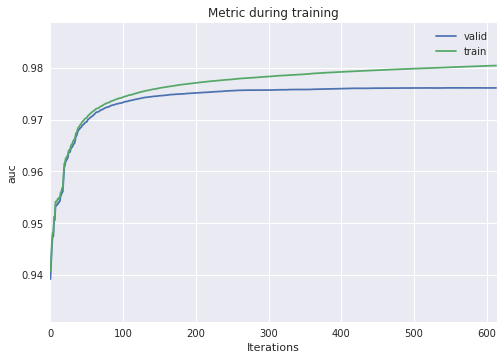

Plot feature importances...


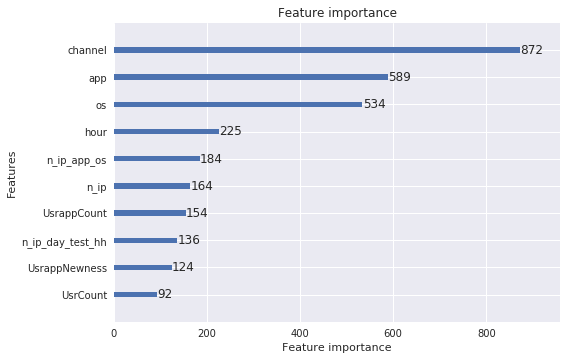

In [ ]:
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_results, metric='auc')
plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(lgbm_model, max_num_features=10)
plt.gcf().savefig('test2.png')

# xbgboost

In [33]:
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
validation_boundary = 5000000
test_df = train_data[length_of_train:]
train_df, validation_df = train_test_split(train_data[:length_of_train], test_size=0.33, random_state=202109)
#validation_df = train_data[(length_of_train-validation_boundary):length_of_train]
#train_df = train_data[:(length_of_train-validation_boundary)]

print("train size: ", len(train_df))
print("valid size: ", len(validation_df))
print("test size : ", len(test_df))

train size:  33500000
valid size:  16500000
test size :  18790469


In [45]:
params = {'eta': 0.3,
          'tree_method': "hist", # Fast histogram optimized approximate greedy algorithm. 
          'grow_policy': "lossguide", # split at nodes with highest loss change
          'max_leaves': 1400, # Maximum number of nodes to be added. (for lossguide grow policy)
          'max_depth': 0, # 0 means no limit (useful only for depth wise grow policy)
          'subsample': 0.7, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0, # The larger, the more conservative the algorithm will be
          'alpha': 4, # L1 regularization. on weights | large value = more conservative model (maintain more features)
          'objective': 'binary:logistic', 
          'scale_pos_weight': 90,
          'eval_metric': 'auc', 
          'nthread': multiprocessing.cpu_count()-1,
          'random_state': 202109 , 
          'silent': True}

In [35]:
dtrain = xgb.DMatrix(train_df[predictors], train_df[target])
dvalid = xgb.DMatrix(validation_df[predictors], validation_df[target])

In [44]:
validation_df[target].value_counts()

0.0    16459217
1.0       40783
Name: is_attributed, dtype: int64

In [46]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=number_of_iter, evals=watchlist, 
                      early_stopping_rounds = 20, verbose_eval=5)

[0]	train-auc:0.90009	valid-auc:0.900501
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.929877	valid-auc:0.929923
[10]	train-auc:0.952453	valid-auc:0.952943
[15]	train-auc:0.95826	valid-auc:0.958532
[20]	train-auc:0.961177	valid-auc:0.961576
[25]	train-auc:0.963896	valid-auc:0.964238
[30]	train-auc:0.965488	valid-auc:0.96585
[35]	train-auc:0.966604	valid-auc:0.96686
[40]	train-auc:0.967488	valid-auc:0.96766
[45]	train-auc:0.968221	valid-auc:0.968148
[50]	train-auc:0.968646	valid-auc:0.968492
[55]	train-auc:0.969173	valid-auc:0.96887
[60]	train-auc:0.969628	valid-auc:0.969171
[65]	train-auc:0.970144	valid-auc:0.969491
[70]	train-auc:0.970448	valid-auc:0.969733
[75]	train-auc:0.970964	valid-auc:0.970067
[80]	train-auc:0.971192	valid-auc:0.970192
[85]	train-auc:0.971517	valid-auc:0.970347
[90]	train-auc:0.971807	valid-auc:0.970526
[95]	train-auc:0.972033	valid-auc:0.970614
[100]

In [48]:
dtest = xgb.DMatrix(test_df[predictors])

In [49]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype('int')
gc.collect()

28931

In [51]:
print("Predicting...")
sub['is_attributed'] = xgb_model.predict(dtest, ntree_limit=xgb_model.best_ntree_limit)
print("writing...")
save_path = 'xgboost_submission_{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S'))
sub.to_csv(save_path, index=False)
print("done...")

Predicting...
writing...
done...


In [52]:
output_path = "gs://onead-gcpml/ninja_project/output"
cmd = 'gsutil cp {} {}'.format(save_path, output_path)
subprocess.check_call(cmd, shell=True)

0

In [5]:
output_path = "gs://onead-gcpml/ninja_project/output"
cmd = 'gsutil cp {} {}'.format('./sub_it.csv', output_path)
subprocess.check_call(cmd, shell=True)

0